# 


# Understanding Nabla - Program Transformations (Part 1)

This notebook demonstrates how transformations like `vmap`, `grad` or `jit` modify a Python program in Nabla.

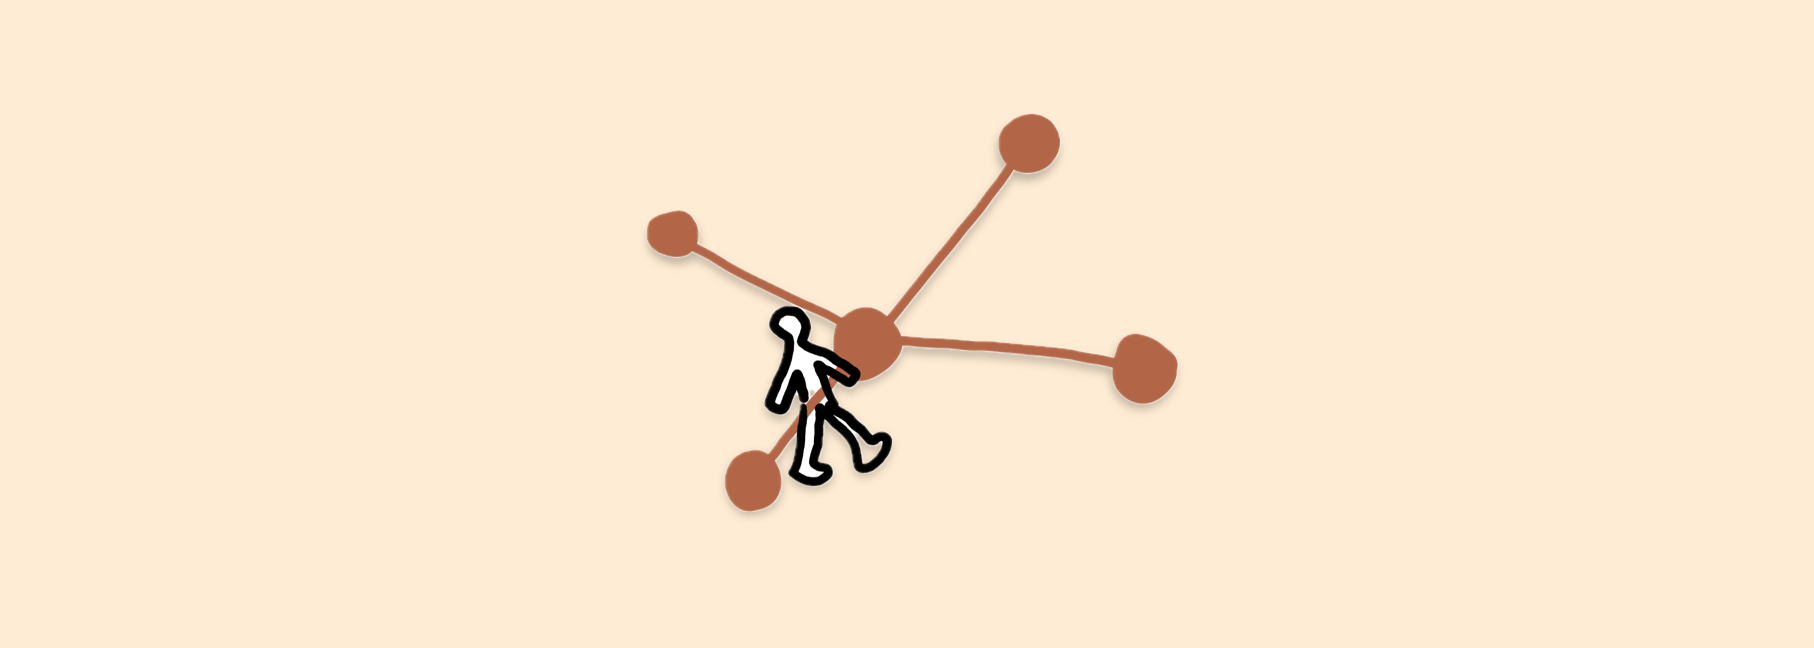

In order to visualize how Nabla works under the hood, we need two things:

- `nabla.xpr(<function>, *<args>)` - Shows intermediate representation of a traced program: inputs → operations → outputs  
- `nabla.jit(<function>, show_graph=True)` - Shows compiled MAX graph (JIT only). The JIT-trafo transforms the intermediate representation into optimized machine code. 

## 1. Defining and Visualizing a Python Function

In [8]:
import nabla as nb


def function(input):
    return nb.sum(input * 2 * input, axes=0)


input = nb.randn((5,))
print("Base XPR:", nb.xpr(function, input))
print("\nres:", function(input))

Base XPR: { lambda (a:f32[5]) ;
  let
    b:f32[] = 2.0
    c:f32[5] = mul a b
    d:f32[5] = mul c a
    e:f32[1] = sum[axes=[-1]] d
    f:f32[] = squeeze[axes=[-1]] e
  in f }

res: 25.47862:f32[]


## 3. Gradient Transformation
`nb.grad()` transforms the program by adding `vjp-nodes` during backward pass.

In [9]:
grad_function = nb.grad(function)
print("Gradient XPR:", nb.xpr(grad_function, input))
print("\nGradient res:", grad_function(input))

Gradient XPR: { lambda (a:f32[5]) ;
  let
    b:f32[] = array(1., dtype=float32)
    c:f32[1] = unsqueeze[axes=[-1]] b
    d:f32[5] = broadcast[shape=(5,)] c
    e:f32[5] = shallow_copy a
    f:f32[] = 2.0
    g:f32[5] = mul e f
    h:f32[5] = mul d g
    i:f32[5] = mul d e
    j:f32[5] = mul i f
    k:f32[5] = add h j
  in k }

Gradient res: [7.0562096 1.6006289 3.914952  8.9635725 7.470232 ]:f32[5]


## 4. Vectorization Transformation
`nb.vmap()` adds batch processing. **Blue numbers** in shapes indicate batched dimensions (vs pink for regular dims).

In [10]:
vmapped_grad_function = nb.vmap(nb.grad(function), in_axes=0)
batched_input = nb.randn((3, 5))
print("Vectorized XPR:", nb.xpr(vmapped_grad_function, batched_input))
print("\nVectorized res:", vmapped_grad_function(batched_input))

Vectorized XPR: { lambda (a:f32[3,5]) ;
  let
    b:f32[3] = shallow_copy
    c:f32[3,1] = unsqueeze[axes=[-1]] b
    d:f32[3,5] = broadcast[shape=(5,)] c
    e:f32[3,5] = incr_batch_dim_ctr a
    f:f32[3,5] = permute_batch_dims[axes=(-1,)] e
    g:f32[3,5] = shallow_copy f
    h:f32[] = 2.0
    i:f32[3,5] = mul g h
    j:f32[3,5] = mul d i
    k:f32[3,5] = mul d g
    l:f32[3,5] = mul k h
    m:f32[3,5] = add j l
    n:f32[3,5] = permute_batch_dims[axes=(-1,)] m
    o:f32[3,5] = decr_batch_dim_ctr n
  in o }

Vectorized res: [[ 7.0562096   1.6006289   3.914952    8.9635725   7.470232  ]
 [-3.9091115   3.8003538  -0.6054288  -0.4128754   1.6423941 ]
 [ 0.57617426  5.817094    3.0441508   0.48670006  1.775453  ]]:f32[3,5]


## 5. Compilation Transformation with MAX

In [11]:
jitted_vmapped_grad_function = nb.jit(nb.vmap(nb.grad(function)), show_graph=True)
res = jitted_vmapped_grad_function(batched_input)
print("\nJitted Vectorized res:", res)

mo.graph @nabla_graph(%arg0: !mo.tensor<[3, 5], f32, cpu:0>) -> !mo.tensor<[3, 5], f32, cpu:0> attributes {argument_names = ["input0"], inputParams = #kgen<param.decls[]>, result_names = ["output0"]} {
  %0 = mo.chain.create()
  %1 = mo.constant {value = #M.dense_array<2.000000e+00> : tensor<f32>} : !mo.tensor<[], f32, cpu:0>
  %2 = mo.constant {value = #M.dense_array<1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00> : tensor<3x5xf32>} : !mo.tensor<[3, 5], f32, cpu:0>
  %3 = rmo.mul(%2, %arg0) : (!mo.tensor<[3, 5], f32, cpu:0>, !mo.tensor<[3, 5], f32, cpu:0>) -> !mo.tensor<[3, 5], f32, cpu:0>
  %4 = rmo.mul(%3, %1) : (!mo.tensor<[3, 5], f32, cpu:0>, !mo.tensor<[], f32, cpu:0>) -> !mo.tensor<[3, 5], f32, cpu:0>
  %5 = rmo.mul(%arg0, %1) : (!mo.tensor<[3, 5], f32, cpu:0>, !mo.tensor<[], f32, cpu:0>) -> !mo.tensor<[3, 5], f32, cpu: